In [171]:
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline 
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np 
import xgboost as xgb
from matplotlib.offsetbox import AnchoredText
import heapq
import math 
import statistics 
from nasspython.nass_api import nass_data
from NdviApi import NDVI
import seaborn as sns

In [172]:
plt.style.use('ggplot')

In [173]:
""" 
Helpful Links:
https://geo.fas.usda.gov/GADAS/index.html#
https://glam1.gsfc.nasa.gov/
https://www.mdpi.com/2072-4292/13/21/4227
https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
"""

' \nHelpful Links:\nhttps://geo.fas.usda.gov/GADAS/index.html#\nhttps://glam1.gsfc.nasa.gov/\nhttps://www.mdpi.com/2072-4292/13/21/4227\nhttps://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db\n'

In [174]:

# Generic function to initialize dataframes from USDA Quickstats data
def initialize_df(states, week, start_yr, end_yr, freq, suffix, var):
    temp = pd.DataFrame(nass_data("B3744D45-DFBE-3B88-AFB1-25CBC8E64550", agg_level_desc="STATE", freq_desc=freq, short_desc=var)['data'])
    temp = temp[temp["state_name"].isin(states)]
    if (freq == "WEEKLY"):
        temp = temp[temp["reference_period_desc"].eq(f"WEEK #{week}")]
    elif (freq == "ANNUAL"):
        temp = temp[temp["reference_period_desc"].eq("YEAR")]
    temp = temp[temp["year"].ge(start_yr) & temp["year"].le(end_yr)]
    temp = temp.pivot(index='year', columns='state_name', values="Value")
    temp = temp.add_suffix(suffix)
    temp = temp.replace(",", "", regex=True)
    temp = temp.fillna(0).astype(float)
    return temp 

In [175]:

# NDVI data via https://glam1.gsfc.nasa.gov/
def get_ndvi_data(states, ids, mask, threshold, index):
    acc_ndvi_df = pd.DataFrame(index=index)
    for i in range(len(ids)):
        acc_ndvi = list()
        df = NDVI().get_data(
                            version='v15', 
                            sat='MOD',
                            mask=mask, 
                            shape='ADM',
                            start_yr=2000,
                            end_yr=2024,
                            start_month=1,
                            num_months=12,
                            ids=ids[i],
                            ts_type='cumulative',
                            mcv=0.0
                            )
        count=0
        for j in range(df.shape[0]):
            if (int(df.loc[j, "ORDINAL DATE"][-3:]) == 329):
                acc_ndvi.append(count)
                count=0
            elif (df.loc[j, "SAMPLE VALUE"] >= threshold): 
                count+=df.loc[j, "SAMPLE VALUE"] 
        acc_ndvi_df[states[i] + " NDVI"] = acc_ndvi  
    return acc_ndvi_df

In [176]:

# Drought index data from https://droughtmonitor.unl.edu/About.aspx
def get_drought_data(states, ids, start_yr, end_yr, index):
    drought_data = pd.DataFrame(index=index)
    for i in range (len(ids)):
        if len(str(ids[i])) == 1:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi=0{ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        else:
            df = pd.read_json(f"https://usdmdataservices.unl.edu/api/StateStatistics/GetDroughtSeverityStatisticsByArea?aoi={ids[i]}&startdate=1/1/{start_yr}&enddate=1/1/{end_yr+1}&statisticsType=1")
        df = df.loc[:, ["ValidStart", "None", "D0", "D1", "D2", "D3", "D4"]]
        df["ValidStart"] = pd.to_datetime(df["ValidStart"]).dt.to_period('Y')
        df = df.iloc[::-1].set_index("ValidStart", drop=True)
        df = df.replace(",", "", regex=True)
        df = df.fillna(0).astype(float)
        df = df.groupby(lambda x: x.year)[["None", "D0", "D1", "D2", "D3", "D4"]].mean()
        df.index.name = None
        df = df.add_prefix(f"{states[i]} ")
        drought_data = pd.concat([drought_data, df], axis=1)
    return drought_data

In [177]:
"""
Function to initialize data

Pass crop, week to take data from, and array of 1s and 0s indicating which additional variables to include.

Available crops are "CORN", "WHEAT, WINTER" and "SOYBEAN"

Below are the available variables, in order:
1. PCT Excellent at current week
2. PCT Good at current week
3. PCT Change in Excellent (pct @ week - pct @ week - 10)
4. PCT Change in Good (pct @ week - pct @ week - 10)
5. Acres planted/year
6. Acres harvested at current week
7. PCT Mature at current week
8. Drought data
9. PCT Fair at current week
10. PCT Poor at current week
11. PCT Very Poor at current week


Sample input below
"""


def get_data(crop, week, start_yr=2000, end_yr=2023, var_arr=[], forecast=False):
    
    if (crop == "CORN"):
        mask = "USDA-NASS-CDL_2018-2023_corn-50pp"
        states = ["WISCONSIN", "SOUTH DAKOTA", "OHIO", "NEBRASKA", "MISSOURI", "MINNESOTA", "KANSAS", "IOWA", "INDIANA", "ILLINOIS"]
        ndvi_ids = [26264, 26237, 26258, 26228, 26253, 26251, 26226, 26246, 26245, 26244]
        drought_ids = [55, 46, 39, 31, 29, 27, 20, 19, 18, 17]
        threshold = 0.58
    elif (crop == "SOYBEANS"):
        mask = "USDA-NASS-CDL_2018-2023_soybean-50pp"
        states = ["SOUTH DAKOTA", "OHIO", "NORTH DAKOTA", "NEBRASKA", "MISSOURI", "MINNESOTA", "IOWA", "INDIANA", "ILLINOIS", "ARKANSAS"]
        ndvi_ids = [26237, 26258, 26236, 26228, 26253, 26251, 26246, 26245, 26244, 26240]
        drought_ids = [46, 39, 38, 31, 29, 27, 19, 18, 17, 5]
        threshold = 0.58
    elif (crop == "WHEAT, WINTER"):
        mask = "USDA-NASS-CDL_2018-2023_winterwheat-50pp"
        states = ["WASHINGTON", "SOUTH DAKOTA", "OKLAHOMA", "NEBRASKA", "MONTANA", "MISSOURI", "KANSAS", "ILLINOIS", "IDAHO", "COLORADO"]
        ndvi_ids = [26234, 26237, 26230, 26228, 26227, 26253, 26226, 26244, 26225, 26224]
        drought_ids = [53, 46, 40, 31, 30, 29, 20, 17, 16, 8]
        threshold = 0.34

    idx = list(range(start_yr, end_yr + 1))
    """
    Get crop mask from: https://glam1.gsfc.nasa.gov/api/doc/db/versions#default-db
    """
    df = get_ndvi_data(states, ndvi_ids, mask=mask, threshold=threshold, index=idx)
    if not forecast:
        if (crop == "CORN"):
            yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", "CORN, GRAIN - YIELD, MEASURED IN BU / ACRE")
        else:
            yields = initialize_df(states, None, start_yr, end_yr, "ANNUAL", "", f"{crop} - YIELD, MEASURED IN BU / ACRE")

    overlay = pd.DataFrame()
    
    additional_vars = {
                    0: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    1: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    2: f"{crop} - CONDITION, MEASURED IN PCT EXCELLENT",
                    3: f"{crop} - CONDITION, MEASURED IN PCT GOOD",
                    4: "PCT CHNGE EXCELLENT",
                    5: "PCT CHNGE GOOD",
                    6: f"{crop} - ACRES PLANTED",
                    7: f"{crop} - PROGRESS, MEASURED IN PCT HARVESTED",
                    8: f"{crop} - PROGRESS, MEASURED IN PCT MATURE",
                    9: "Drought data" ,
                    10: f"{crop} - CONDITION, MEASURED IN PCT FAIR",
                    11: f"{crop} - CONDITION, MEASURED IN PCT POOR",
                    12: f"{crop} - CONDITION, MEASURED IN PCT VERY POOR",
    }

    for i in range(11):
        if var_arr[i] == 1:
            if i == 2:
                excellent_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " EXCLNT 10 WK CHNGE", additional_vars[i])
                excellent_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " EXCLNT 10 WK CHNGE", additional_vars[i])
                pct_chnge_excellent = excellent_34 - excellent_24
                overlay = pd.concat([overlay, pct_chnge_excellent], axis=1)
            elif i == 3:
                good_24 = initialize_df(states, week - 10, start_yr, end_yr, "WEEKLY", " GD 10 WK CHNGE", additional_vars[i])
                good_34 = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " GD 10 WK CHNGE", additional_vars[i])
                pct_chnge_good = good_34 - good_24
                overlay = pd.concat([overlay, pct_chnge_good], axis=1)
            elif i == 4:
                planted = initialize_df(states, None, start_yr, end_yr, "ANNUAL", " ACRES PLANTED", additional_vars[6])
                overlay = pd.concat([overlay, planted], axis=1)
            elif i == 5:
                if (crop == "CORN"):
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", "CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED")
                else:
                    harvested = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " ACRES HARVESTED", additional_vars[7])
                overlay = pd.concat([overlay, harvested], axis=1)
            elif i == 6:
                maturity = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT MATURE", additional_vars[8])
                overlay = pd.concat([overlay, maturity], axis=1)
            elif i == 7:
                drought_index = get_drought_data(states, drought_ids, start_yr, end_yr, idx)
                overlay = pd.concat([overlay, drought_index], axis=1)
            elif i == 8:
                fair = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT FAIR", additional_vars[10])
                overlay = pd.concat([overlay, fair], axis=1)
            elif i == 9:
                poor = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT POOR", additional_vars[11])
                overlay = pd.concat([overlay, poor], axis=1)
            elif i == 10:
                very_poor = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT VERY POOR", additional_vars[12])
                overlay = pd.concat([overlay, very_poor], axis=1)
            elif i == 0:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT EXCELLENT", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)   
            elif i == 1:
                temp = initialize_df(states, week, start_yr, end_yr, "WEEKLY", " PCT GOOD", additional_vars[i])
                overlay = pd.concat([overlay, temp], axis=1)

    
    x = pd.concat([df, overlay], axis=1)
    x.fillna(0, inplace=True)
    cols = x.columns
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=cols)   

    x.head()
    if not forecast:
        return yields, x
    else:
        return x


In [178]:

# Extra Vegetation Health index (VHI) data for corn (just call the function if you want it). Taken out due to noise

vhi_links = ["https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=14&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=15&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=16&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=17&country=USA&yearlyTag=Yearly&type=Parea_VCI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=24&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=26&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=28&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=36&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=42&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024",
             "https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/get_TS_admin.php?provinceID=50&country=USA&yearlyTag=Yearly&type=Parea_VHI&TagCropland=MAIZ&year1=1982&year2=2024"]

def get_vhi_data(links):
    for i in range(len(links)):
        global x 
        vhi = pd.read_csv(links[i], skiprows=3)
        vhi = vhi.iloc[list(range(17, 41)), :]
        vhi.reset_index(inplace=True)
        vhi.set_index(vhi.columns[1], drop=True, inplace=True)
        vhi.drop(columns="index", inplace=True)
        vhi.index.name = None
        VHI_bins = list(range(0, 105, 5))
        vhi.drop(columns="Unnamed: 22", inplace=True)
        vhi.columns = VHI_bins
        vhi = vhi.add_prefix(y.columns[i] + " VHI Bin")
        vhi.index = x.index 
        x = pd.concat([x, vhi], axis=1)

In [179]:
def pairplots():
    global x 
    global y 
    for state in y.columns:
        state_data = x.filter(regex=state)
        temp = pd.DataFrame(y[state], columns=[state])
        temp.reset_index(drop=True, inplace=True)
        g = sns.pairplot(state_data.assign(yields=temp[state]), y_vars=['yields'][:], x_vars=state_data.columns)
        sns.despine();

In [180]:
# Optional filtering based on Spearman correlation

def spearman_correlations(filter=True):
    global x 
    global y 
    fig, axs = plt.subplots(5, 2, figsize=(18, 18))

    for i, ax in enumerate(fig.axes):
        state = y.columns[i-1]
        corr = x.filter(regex=state).apply(lambda x: spearmanr(x, y[state])[0])
        if filter:
            temp = abs(corr)
            x.drop(columns=temp.nsmallest(math.floor(len(corr.index) / 2)).index, inplace=True)
        ax.barh(y=corr.index.str.lstrip(state), width=corr.sort_values(), color='lightsteelblue')
        ax.set_title(state);
    
    plt.subplots_adjust(hspace=0.5, wspace=0.4)
    plt.show()

In [181]:
# Optional filtering based on mutual information
def mutual_information(filter=True):
    global x 
    global y 
    fig, axs = plt.subplots(5, 2, figsize=(18, 18))

    for i, ax in enumerate(fig.axes):
        state = y.columns[i-1]
        state_data = x.filter(regex=state)
        mi = mutual_info_regression(X=state_data,
                                    y=y[state],
                                    random_state=42
                                    )
        mutual_info = pd.DataFrame(mi, index=state_data.columns, columns=[state])
        if filter:
            x.drop(columns=mutual_info[state].nsmallest(math.floor(len(mutual_info.index) / 2)).index, inplace=True)
        ax.barh(state_data.columns, mutual_info[state])
        ax.set_title(state)
    plt.tight_layout()


In [182]:

# Returns feature coefficients of regression model
def feature_importance(model, df, ax, num_features, plot=False, print_results=False):
        importance = model.coef_
        keys = list(df.keys())
        abs_weights = {}
        weights = {}
        for i,v in enumerate(importance):
            if print_results:
                print("Feature: %s, Score: %.5f" % (keys[i],v))
            abs_weights[keys[i]] = abs(v)
            weights[keys[i]] = v
        if plot:
            ax.bar([x for x in range(len(importance))], height=importance, color='b')
            tickvals = range(0, len(importance))
            cols = df.columns
            ax.set_xticks(ticks=tickvals, labels=cols, rotation=45, fontsize='xx-small', fontstretch='extra-condensed')
        
        largest_features = heapq.nlargest(num_features, abs_weights, key=abs_weights.get)

        avg_abs_weight = sum([abs_weights.get(key) for key in largest_features]) / len(largest_features)
        return largest_features, weights, avg_abs_weight

In [183]:

# Returns optimized model based on RandomSearchCV and specified parameters.

def get_best_model(X, y, kwargs=None, lasso=True, print_results=False, scoring=None, cv=5):
    xgb_params = {
    "learning_rate": np.arange(0.01, 0.2, 0.01),
    "min_child_weight": np.arange(1, 5, 1),
    "n_estimators": range(800, 1200),
    "max_depth": range(1, 5),
    "colsample_bytree": np.arange(0.1, 1, 0.1),
    "subsample": np.arange(0.1, 1, 0.1)
    }

    lasso_params = {
        "alpha": np.arange(0.05, 2, 0.05)
    }

    if not lasso:
        optimized_model = RandomizedSearchCV(param_distributions=xgb_params, estimator=xgb.XGBRegressor(), scoring=scoring, verbose=1, random_state=42, cv=2)
        optimized_model.fit(X, y)
        if print_results:
            print("Best Parameters:", optimized_model.best_params_)
    else: 
        optimized_model = RandomizedSearchCV(param_distributions=lasso_params, estimator=Lasso(random_state=42), scoring=scoring, verbose=1, random_state=42, cv=cv)
        optimized_model.fit(X, y)
        if print_results:
            print("Best Parameters:", optimized_model.best_params_)
    return optimized_model

In [184]:
# Fitting models, analyzing and plotting data

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

def reg_plot(x, y, title, ax=None, forecast=False, x_forecast=None):

    
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 0, shuffle=True)
    models = {
    'Linear Regression': LinearRegression(),
    'Lasso' : Lasso(alpha = 0.45, random_state=42),
    'Ridge' : Ridge(random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=3, random_state=42),
    'KNN': KNeighborsRegressor(),
    'XGB': xgb.XGBRegressor(n_estimators=1000,
                            max_depth=3,
                            gamma = 5,
                            subsample = 0.5,
                            random_state=42),
    'XGBRF': xgb.XGBRFRegressor(n_estimators=1000, 
                                subsample = 0.5,
                                random_state=42),
    'RF Regressor': RandomForestRegressor(
                                        random_state=42)
    }
    
    r2_scores = {}
    print(title)
    for name, md in models.items():
        md.fit(X_train,y_train)
        y_pred = md.predict(X_test)
        print(f"{name}: mae : {mean_absolute_error(y_test, y_pred)} score : {r2_score(y_test, y_pred)}")
        r2_scores[md] = r2_score(y_test, y_pred)
    print("-------------")

    model = max(r2_scores, key=lambda x:r2_scores[x])


    # # For most crops, a lower alpha (<= 0.7) is best. Higher alphas run the risk of reducing all coefficients to 0
    # model = RandomForestRegressor(n_estimators=1000, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = pd.DataFrame(model.predict(X_train), index=X_train.index)
    y_test_pred = pd.DataFrame(model.predict(X_test), index=X_test.index)

    combinedX = pd.concat([X_train, X_test], axis=0).sort_index()
    combinedY = pd.concat([y_train, y_test], axis=0).sort_index()
    combinedY_pred = pd.concat([y_train_pred, y_test_pred], axis=0).sort_index()
    ax.plot(combinedX.index, combinedY, label='Actual Yield')
    ax.plot(combinedX.index, combinedY_pred, label='Predicted Yield')
    ax.scatter(X_test.index, y_test_pred, label='Out of Sample Predictions', color='black')
    ax.legend(loc='lower right')
    ax.set_title(title)

    if forecast:
        y_forecast = model.predict(x_forecast)
        ax.plot(y_forecast)
    

    s = r2_score(y_test, y_test_pred)
    best_model = [i for i in models if models[i] == model]
    at = AnchoredText(
        f"CV R2: {s:.2f} \n Model: " + best_model[0],
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

    return ax, s 

In [185]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

In [186]:

def cross_val_curves(x, y, ax):
    X_train = x.iloc[:15]
    y_train = y.iloc[:15]

    rmse_score = make_scorer(rmse)
    cv_rmse = {}
    alphas = list(np.arange(0.1, 3.0, 0.1))
    for alpha in alphas:
        pipe = Pipeline([('scaler', MinMaxScaler()),
                        ('lasso', Lasso(alpha=alpha))])
        cv_rmse[alpha] = cross_val_score(pipe,
                                        X=X_train,
                                        y=y_train,
                                        scoring=rmse_score,
                                        cv=5)


    cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
    best_alpha, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
    cv_rmse = cv_rmse.stack().reset_index()
    cv_rmse.columns=['alpha', 'iter', 'RMSE']
    ax = sns.lineplot(x='alpha', y='RMSE', data=cv_rmse, ax=ax)
    ax.set_title(f'Cross-Validation Results Lasso | Best alpha: {best_alpha} | Best RMSE: {best_rmse:.2f}');

In [187]:
def cv_curves():
    fig, axs = plt.subplots(5, 2, figsize=(18, 18))
    for i, ax in enumerate(fig.axes):
        state = y.columns[i]
        cross_val_curves(x.filter(regex=state), y[state], ax=ax)
    plt.subplots_adjust(hspace=0.5)

ILLINOIS
Linear Regression: mae : 7.509165211678862 score : 0.9185434896952605
Lasso: mae : 6.921706613264348 score : 0.9215207961100607
Ridge: mae : 11.822281580121086 score : 0.7367519033679963
Decision Tree: mae : 10.802777777777777 score : 0.7588950125679698
KNN: mae : 16.600000000000005 score : 0.6147553093259461
XGB: mae : 11.995702107747396 score : 0.7014448444862289
XGBRF: mae : 11.201080322265625 score : 0.7672820850215261
RF Regressor: mae : 9.00666666666666 score : 0.8612584487534628
-------------
INDIANA
Linear Regression: mae : 6.706596251072976 score : 0.8590799642368505
Lasso: mae : 7.813191251852857 score : 0.7755771418948871
Ridge: mae : 8.763045050071668 score : 0.6603730449432091
Decision Tree: mae : 4.833333333333333 score : 0.9089021773680864
KNN: mae : 10.133333333333335 score : 0.6355753337571518
XGB: mae : 9.486663818359375 score : 0.7174387636958004
XGBRF: mae : 12.081410725911459 score : 0.4960959628948175
RF Regressor: mae : 9.823333333333332 score : 0.648796

'\nCORN - MAE -> 33,\nWHEAT - MAE -> 23\nSOYBEANS - MAE -> 42'

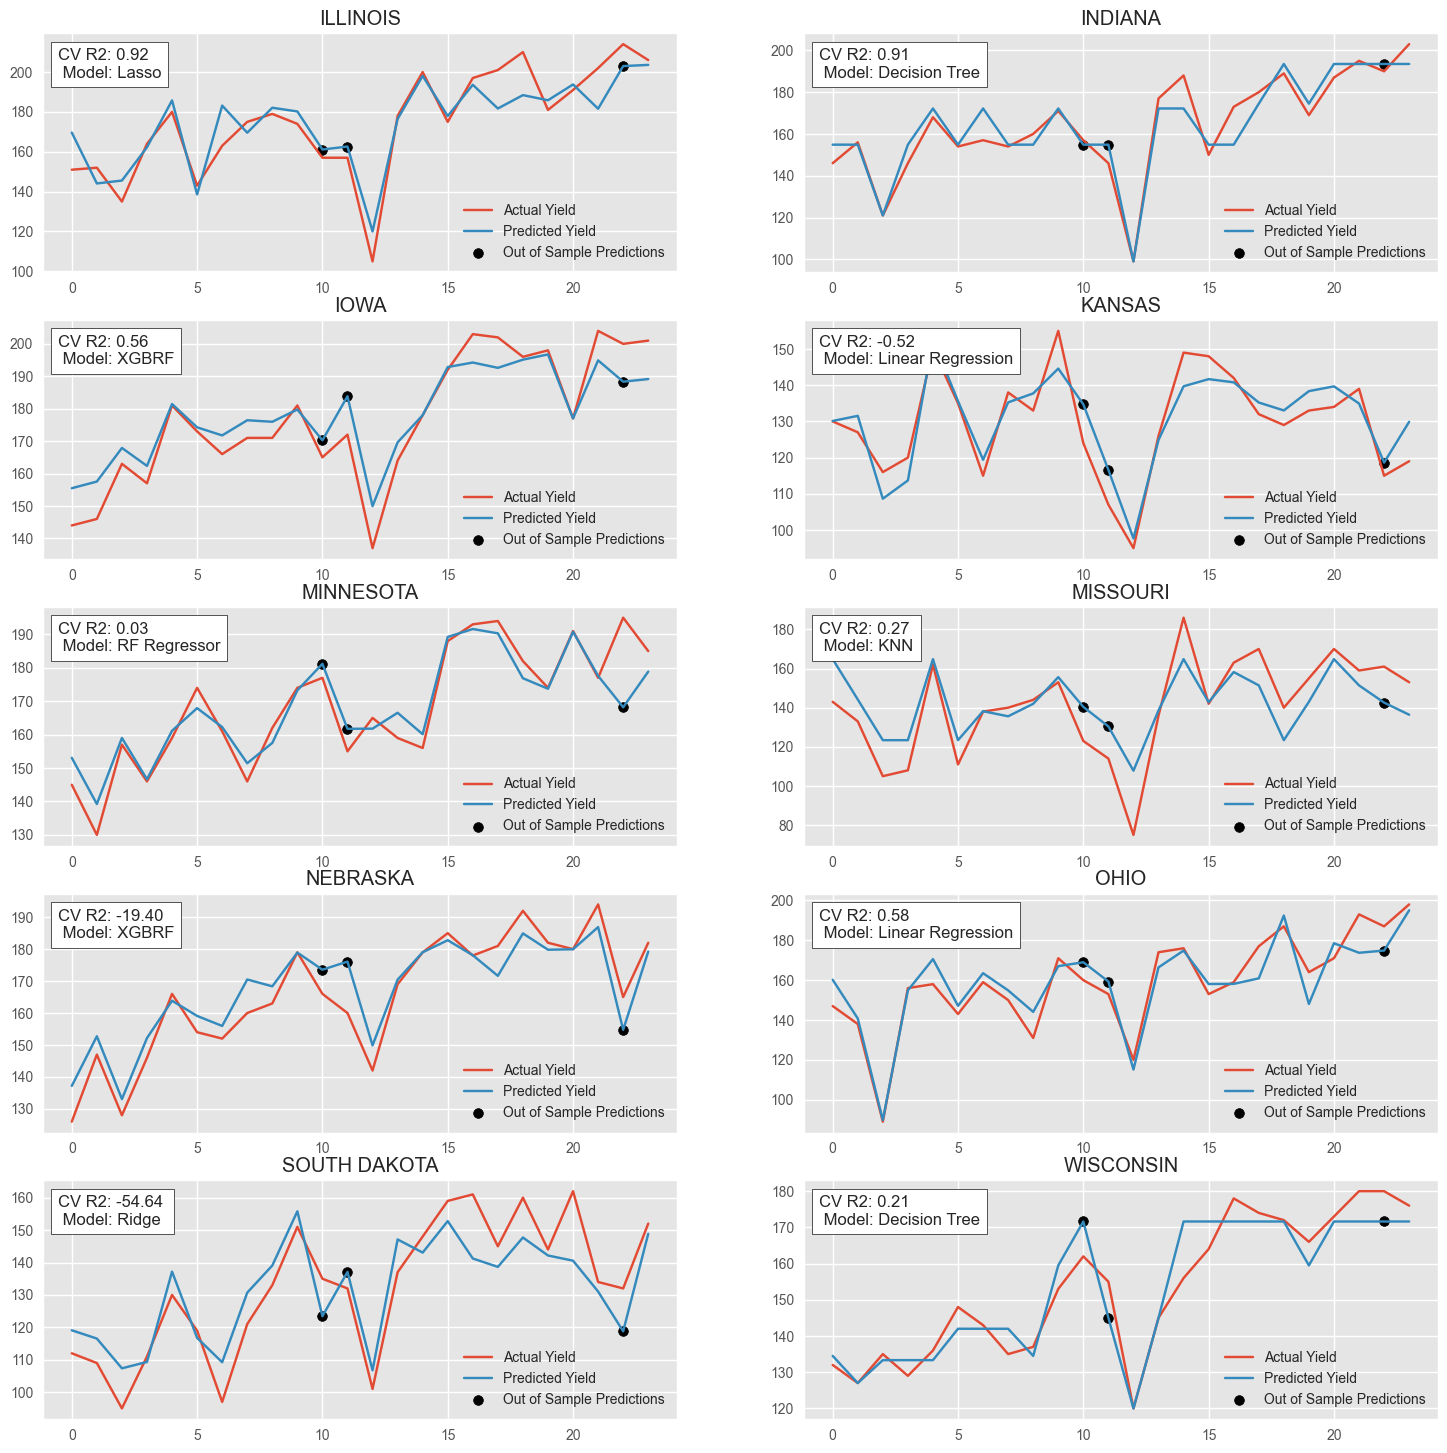

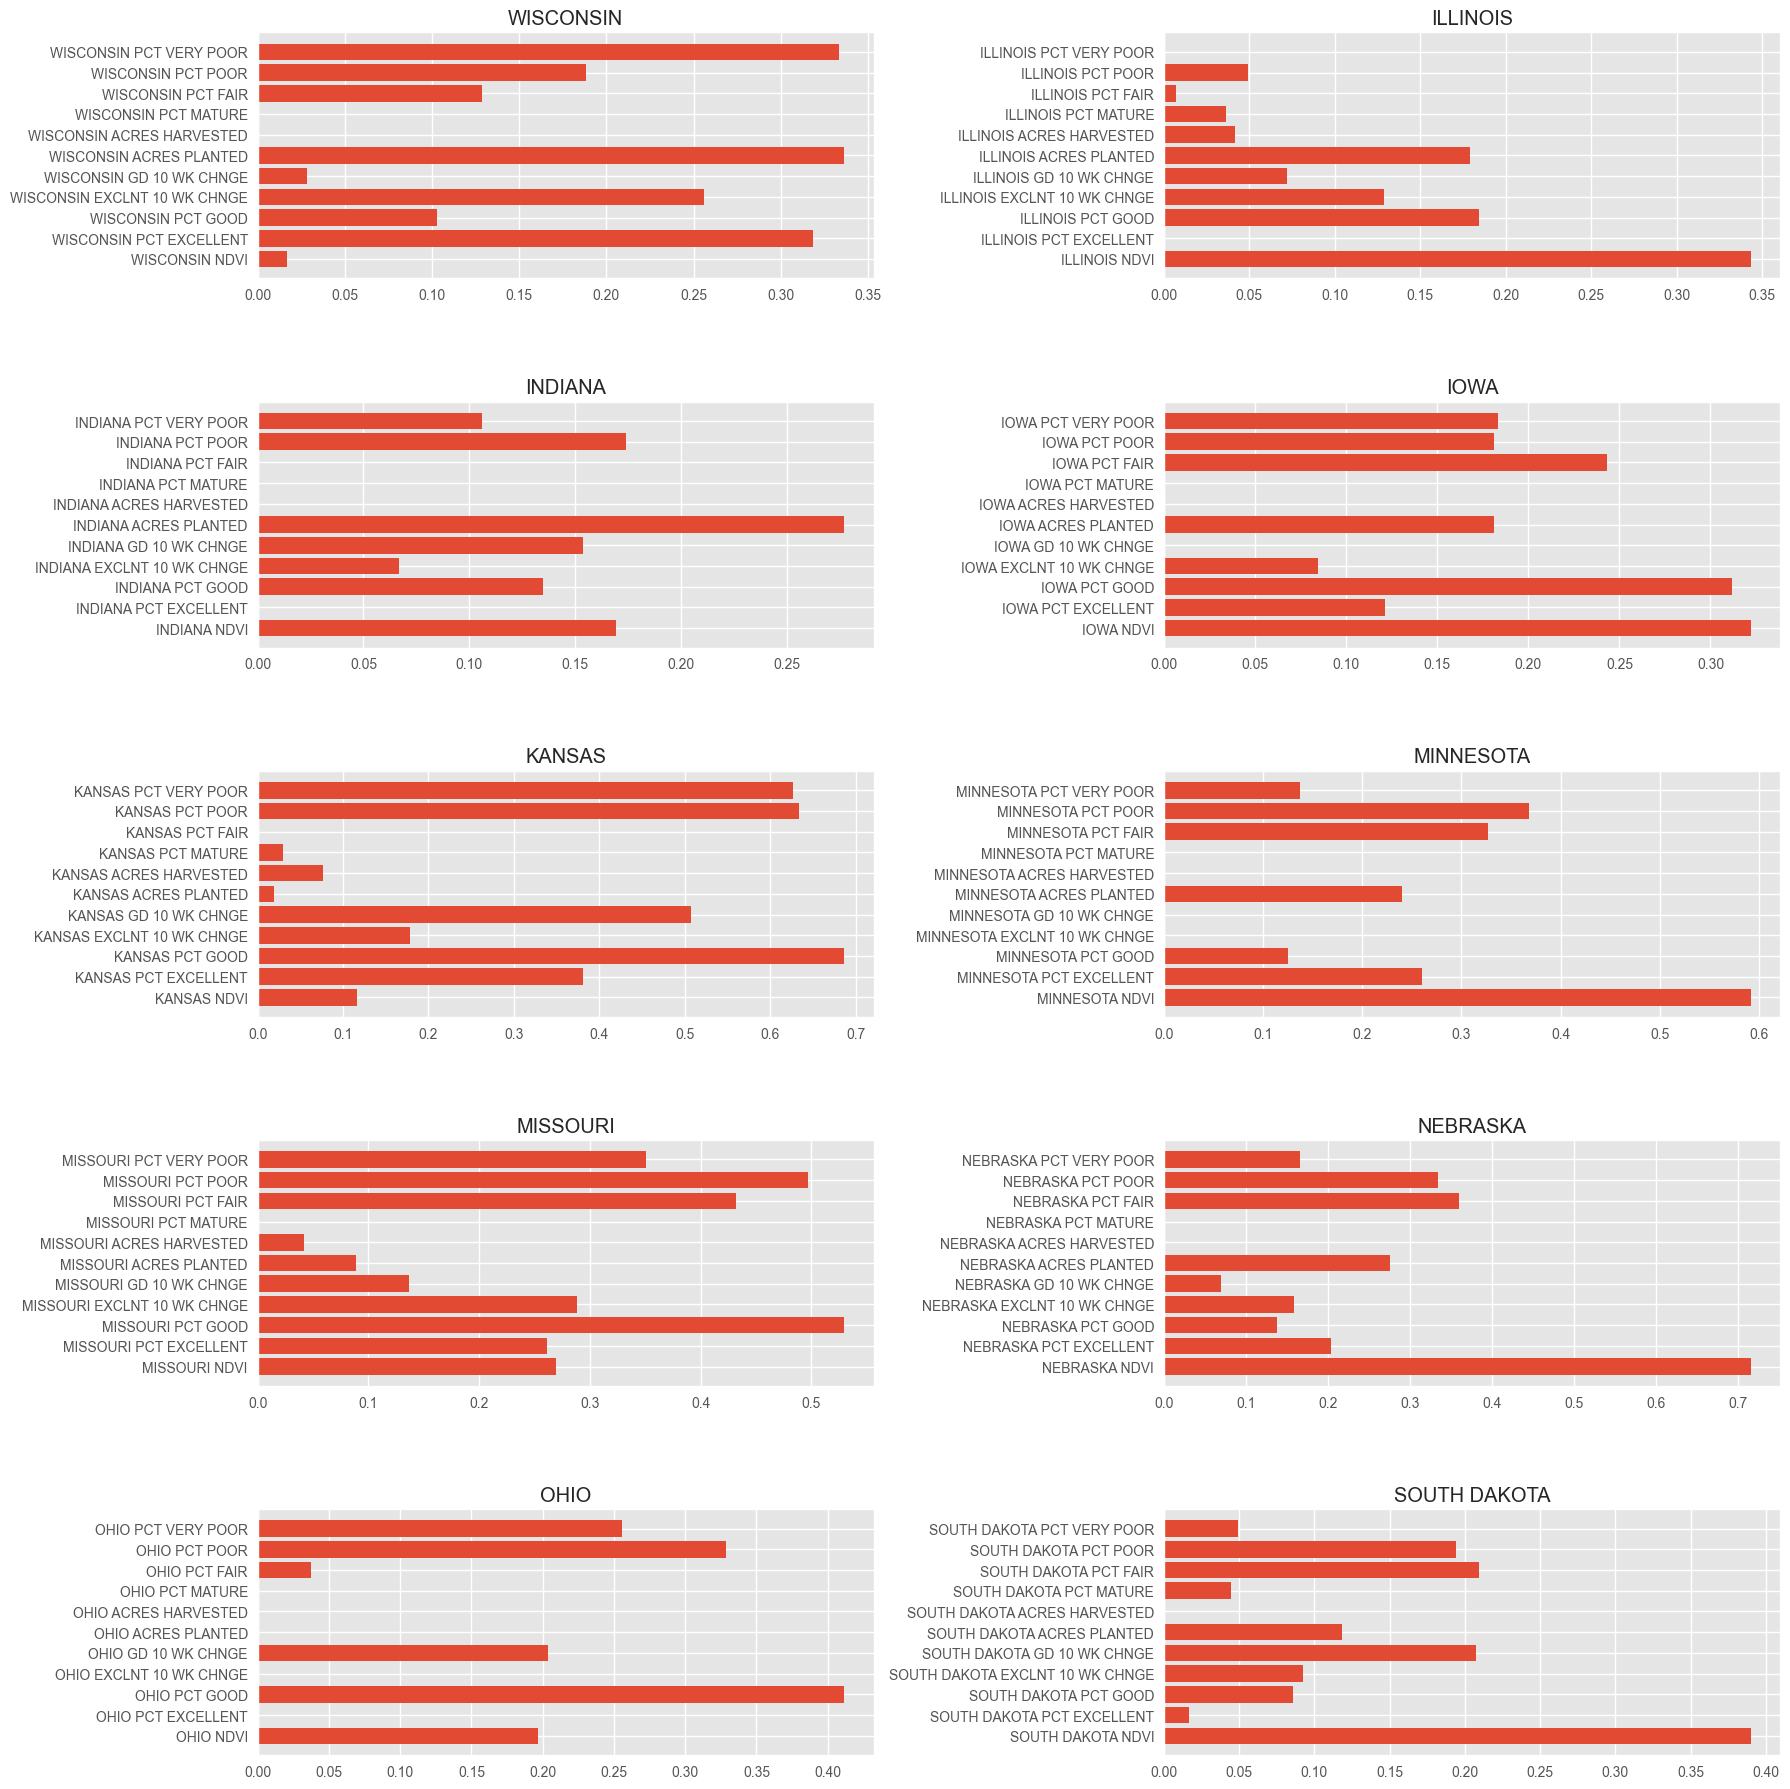

In [188]:


fig, axs = plt.subplots(5, 2, figsize=(18, 18))

r2_by_state = {}
cumulative_r2 = {}
y, x = get_data("CORN", 33, 2000, 2023, [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
mutual_information(filter=True)
for i, ax in enumerate(fig.axes):
        col_name = y.columns[i]
        input = x.filter(regex=col_name)
        _, r2_by_state[col_name] = reg_plot(input, y[col_name], col_name, ax)
plt.subplots_adjust(hspace=0.5)


"""
CORN - MAE -> 33,
WHEAT - MAE -> 23
SOYBEANS - MAE -> 42"""


ARKANSAS
Linear Regression: mae : 2.413453098828531 score : 0.8865984340826973
Lasso: mae : 1.7160268069601063 score : 0.9390725093311888
Ridge: mae : 1.6488673626565458 score : 0.9187501245292811
Decision Tree: mae : 4.238888888888887 score : 0.4074646673560841
KNN: mae : 2.7000000000000006 score : 0.8578490175801448
XGB: mae : 4.050436655680339 score : 0.549297536313665
XGBRF: mae : 3.05088742574056 score : 0.8264267501593081
RF Regressor: mae : 3.473749999999999 score : 0.7698692767580146
-------------
ILLINOIS
Linear Regression: mae : 4.150062265237023 score : 0.49164813776109884
Lasso: mae : 2.257456357683855 score : 0.8445543923322993
Ridge: mae : 3.129425741782067 score : 0.7610841572167492
Decision Tree: mae : 4.2 score : 0.513050193050193
KNN: mae : 3.5333333333333314 score : 0.6844787644787648
XGB: mae : 5.3429718017578125 score : 0.2115357468771284
XGBRF: mae : 4.7728118896484375 score : 0.4583879096276652
RF Regressor: mae : 4.476666666666669 score : 0.39392316602316557
---

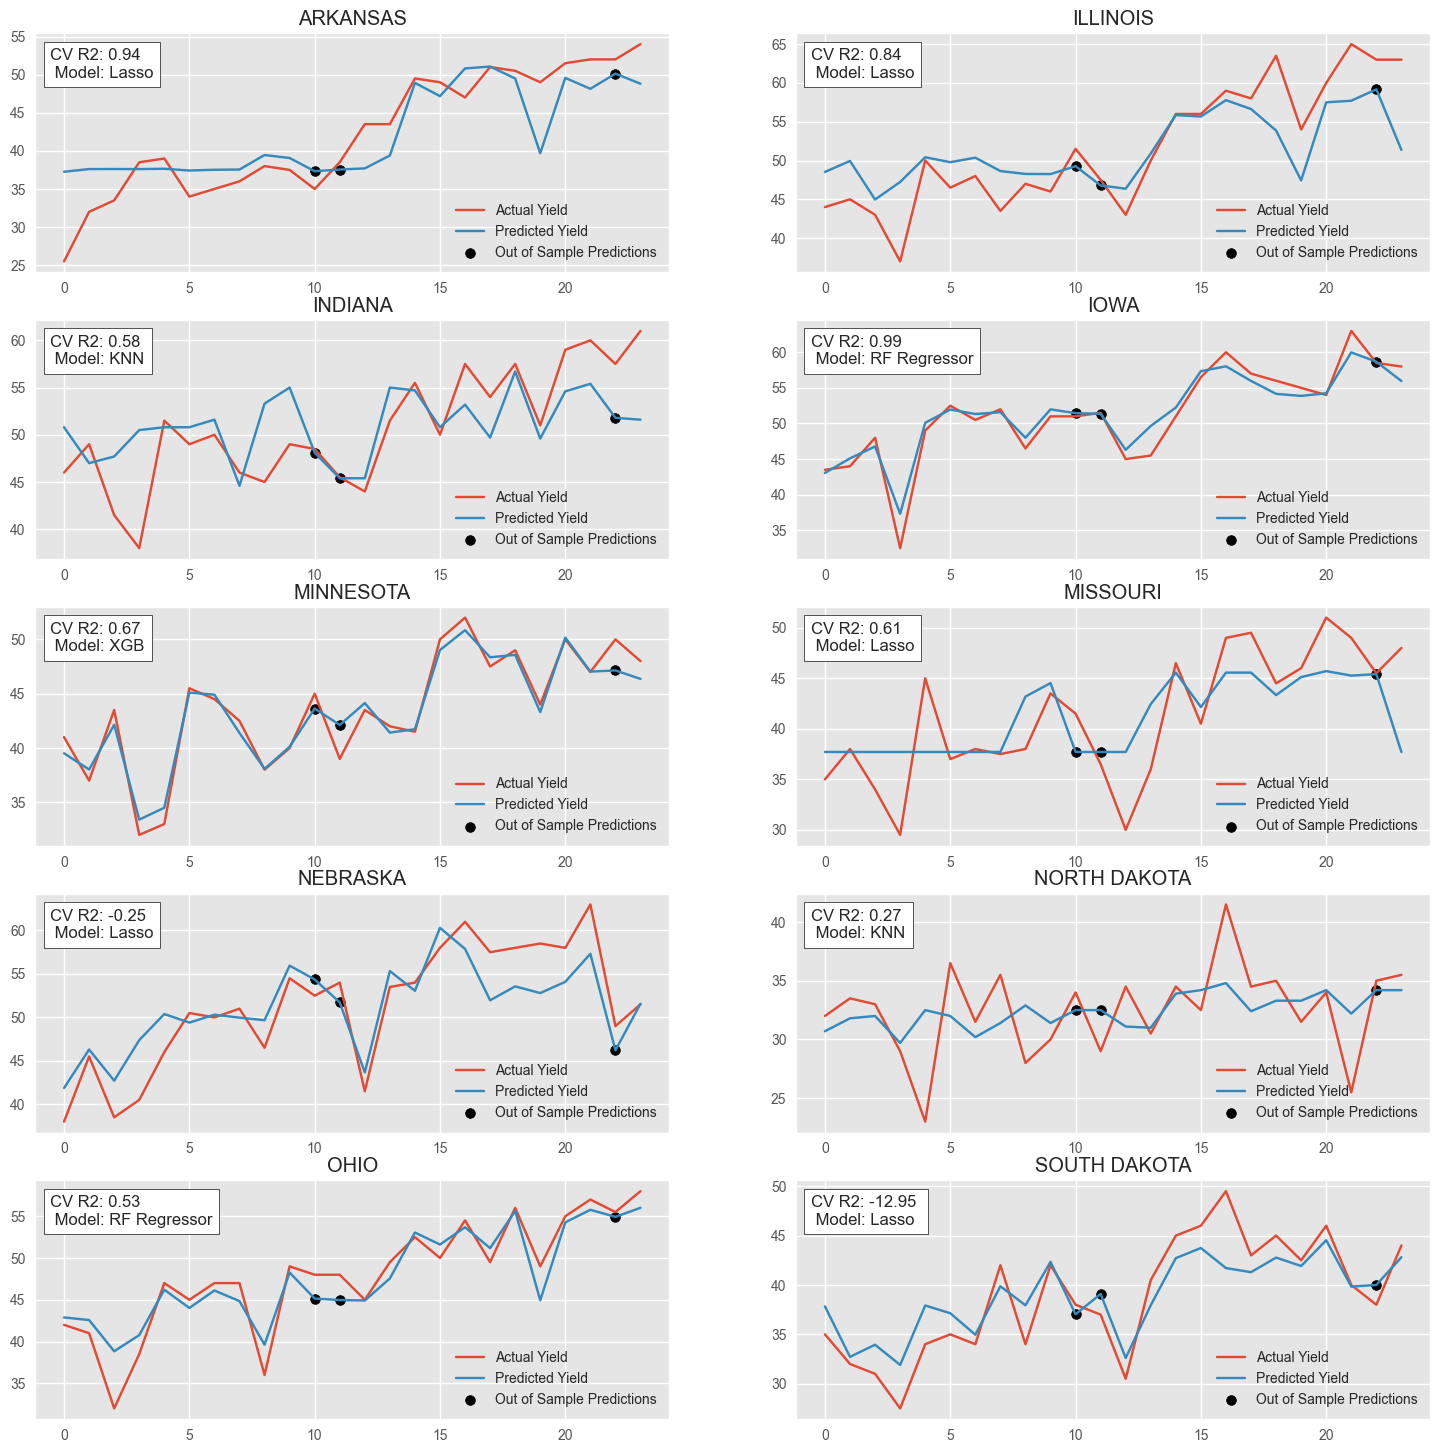

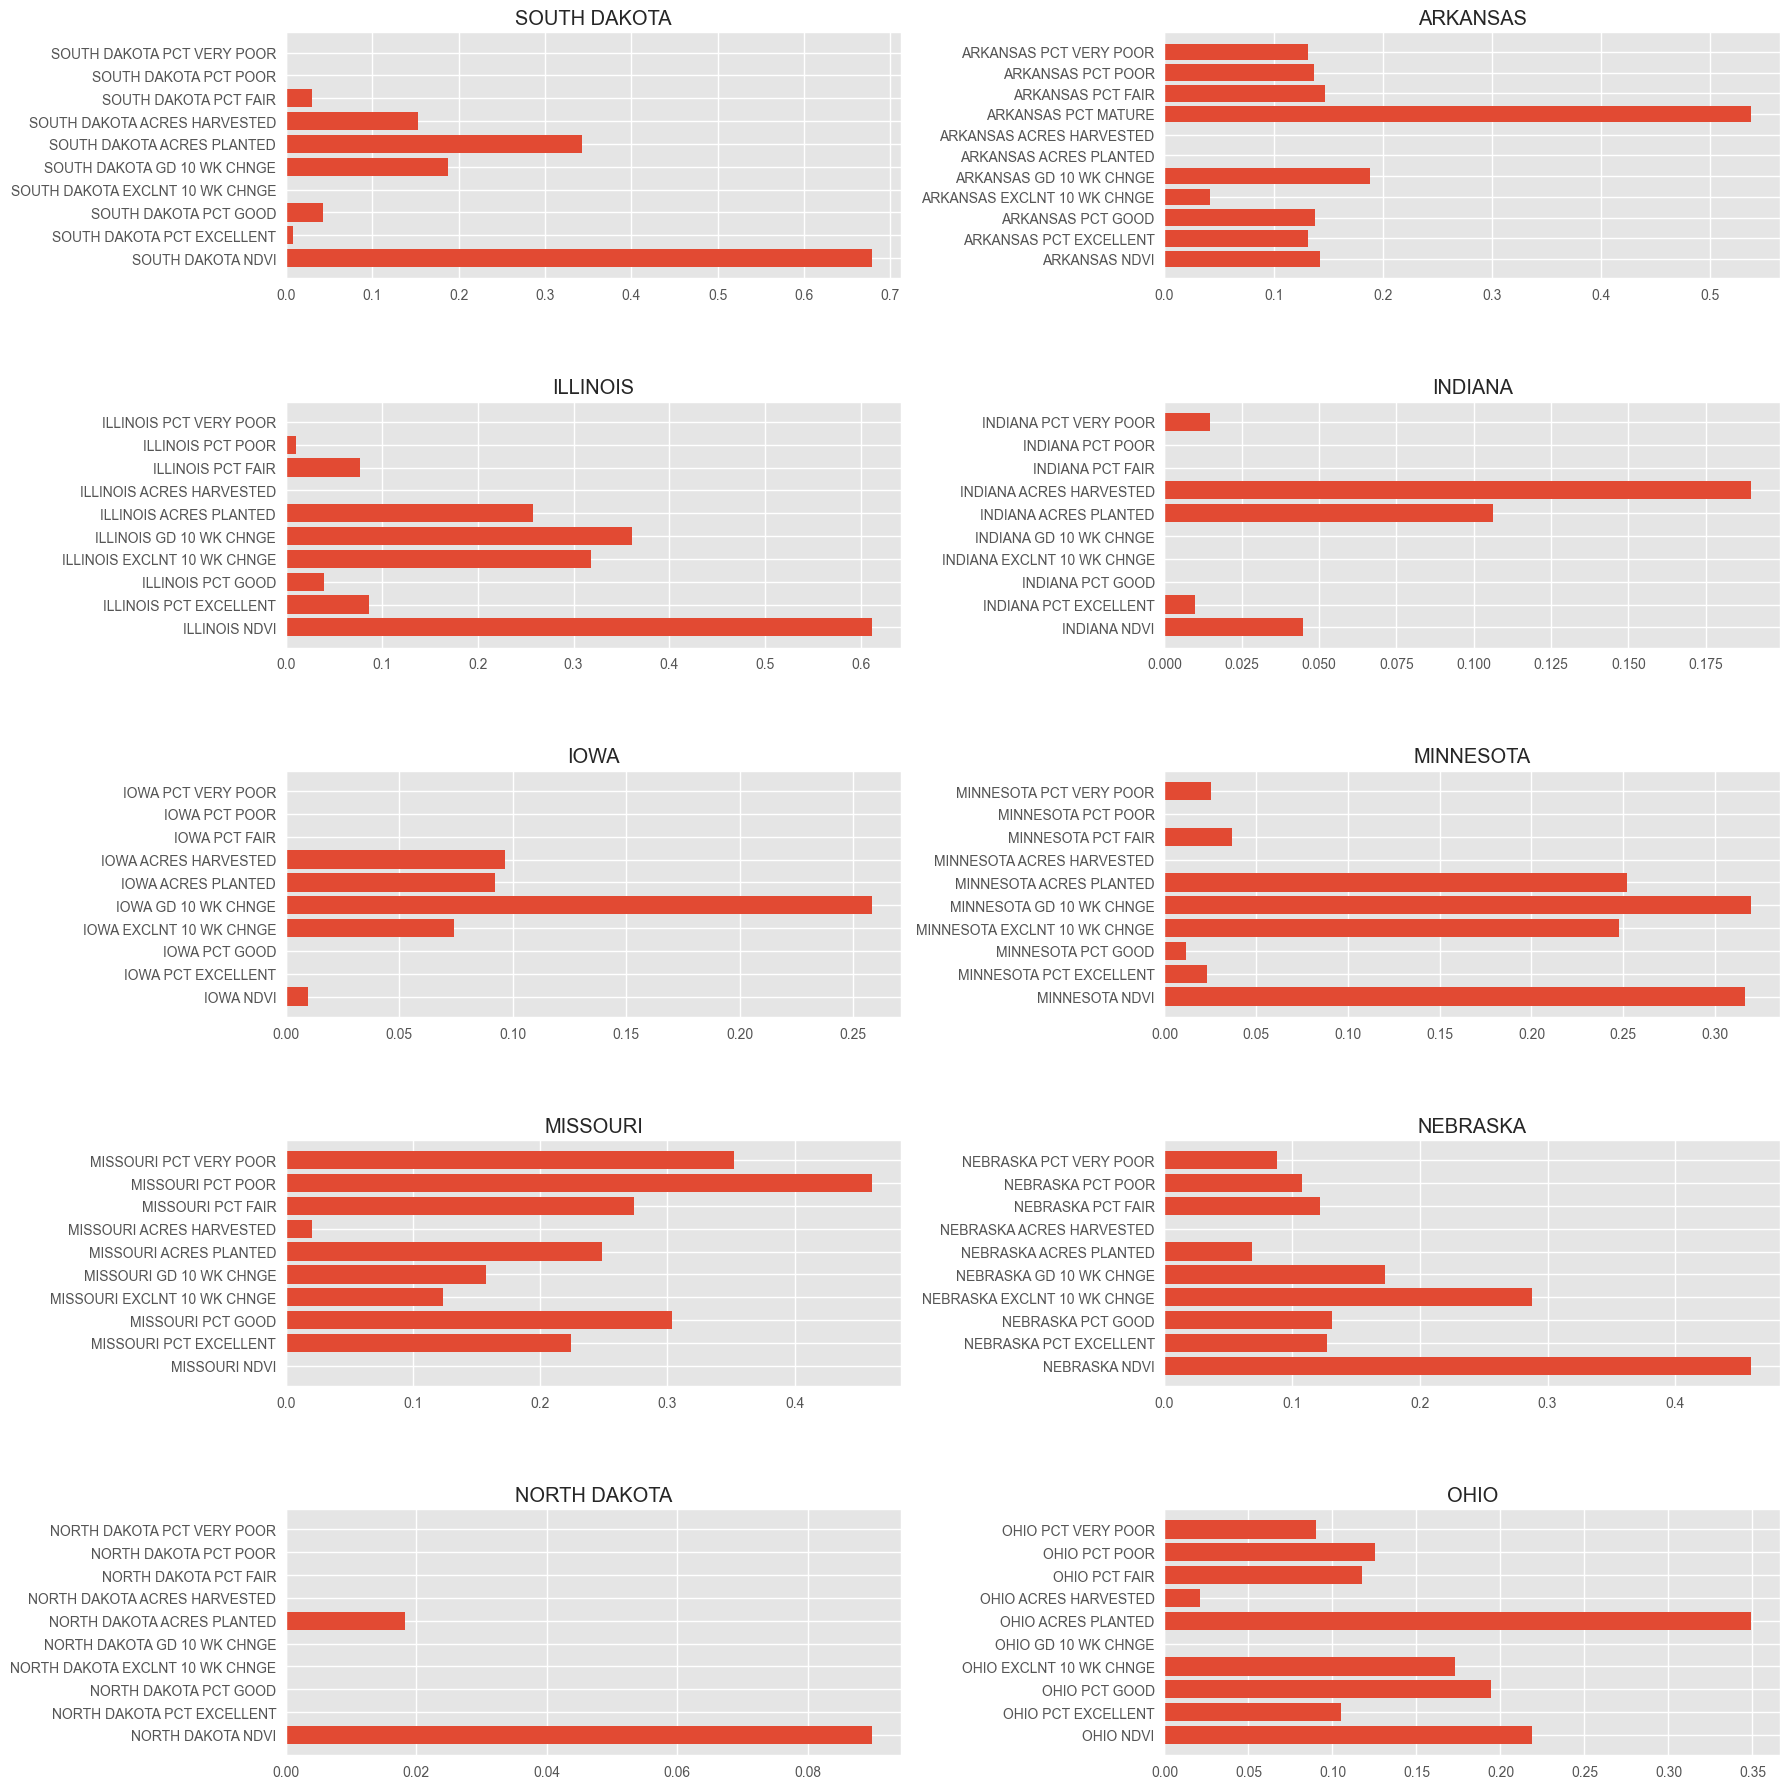

In [189]:

fig, axs = plt.subplots(5, 2, figsize=(18, 18))

r2_by_state = {}
cumulative_r2 = {}
y, x = get_data("SOYBEANS", 42, 2000, 2023, [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
mutual_information(filter=True)
for i, ax in enumerate(fig.axes):
        col_name = y.columns[i]
        input = x.filter(regex=col_name)
        _, r2_by_state[col_name] = reg_plot(input, y[col_name], col_name, ax)
plt.subplots_adjust(hspace=0.5)



COLORADO
Linear Regression: mae : 1.049210397536304 score : 0.9583936216465584
Lasso: mae : 2.6730072155173565 score : 0.8458188148117535
Ridge: mae : 1.960145602392971 score : 0.9012315735695725
Decision Tree: mae : 5.833333333333333 score : 0.29580026455026465
KNN: mae : 1.7999999999999996 score : 0.9330952380952382
XGB: mae : 2.8025232950846353 score : 0.7579156900863468
XGBRF: mae : 3.3553187052408853 score : 0.6915006284140136
RF Regressor: mae : 3.2933333333333317 score : 0.7946392857142859
-------------
IDAHO
Linear Regression: mae : 2.2135342340704605 score : 0.5879221853703376
Lasso: mae : 2.0405144410033196 score : 0.6317987844346432
Ridge: mae : 2.0136400094323315 score : 0.659481600877898
Decision Tree: mae : 4.105555555555559 score : -1.376323099415206
KNN: mae : 3.400000000000001 score : -0.48736842105263256
XGB: mae : 6.436592102050781 score : -3.706761462590964
XGBRF: mae : 3.378911336263021 score : -0.3693100918531662
RF Regressor: mae : 3.0599999999999974 score : 0.03

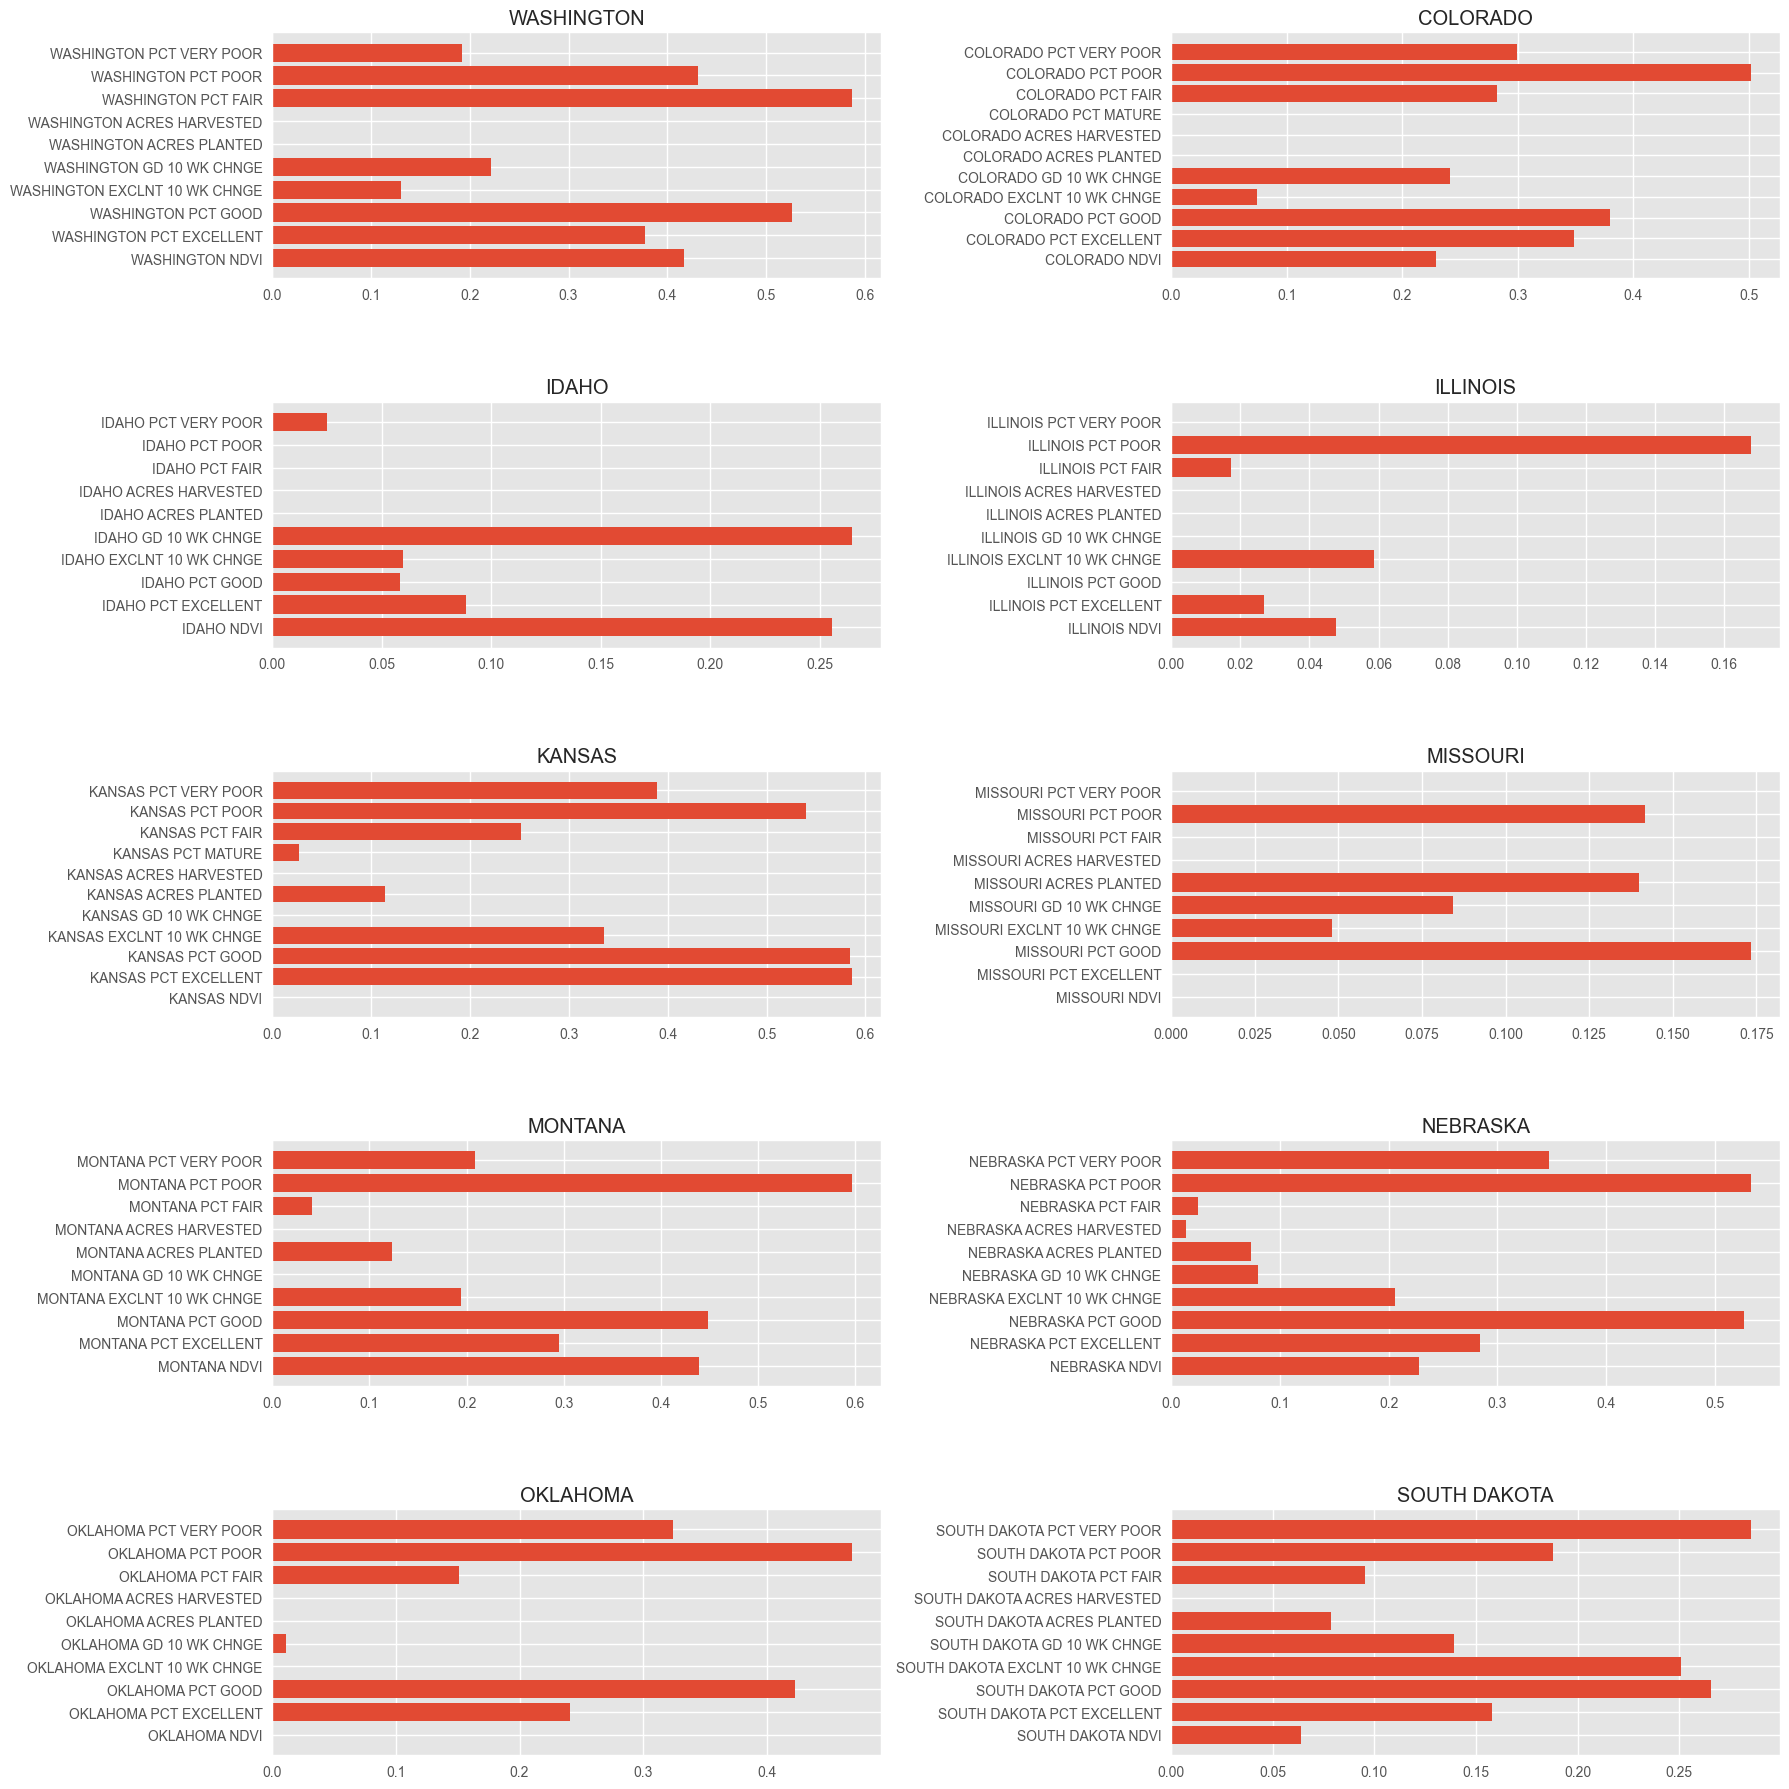

In [190]:
r2_by_state = {}
cumulative_r2 = {}
y, x = get_data("WHEAT, WINTER", 23, 2000, 2023, [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])
mutual_information(filter=True)
for i, ax in enumerate(fig.axes):
        col_name = y.columns[i]
        input = x.filter(regex=col_name)
        _, r2_by_state[col_name] = reg_plot(input, y[col_name], col_name, ax)
plt.subplots_adjust(hspace=0.5)